Using 34 features.
Reference GMM fitted on case=lat200_t235_RUN02, iso=4.5
Reference BIC: -3146086.99

=== Metrics summary (per cluster, per run) ===
                 case_id  cluster    n       r2     rmse method
      lat100_t175_iso4.5        0 2247 0.996600 0.007072   shap
      lat100_t175_iso4.5        1 4329 0.998932 0.003357   shap
      lat100_t175_iso4.5        2  720 0.990659 0.036845   shap
      lat100_t175_iso4.5        3  486 0.981728 0.032807   shap
      lat100_t175_iso4.5        4  275 0.993729 0.052480   shap
      lat100_t212_iso4.5        0 2345 0.993312 0.010345   shap
      lat100_t212_iso4.5        1 4718 0.998017 0.006945   shap
      lat100_t212_iso4.5        2  558 0.986686 0.048875   shap
      lat100_t212_iso4.5        3  909 0.997441 0.012071   shap
      lat100_t212_iso4.5        4  294 0.997476 0.032068   shap
lat200_t235_RUN02_iso4.5        0 4377 0.982976 0.021605   shap
lat200_t235_RUN02_iso4.5        1 6789 0.997223 0.011034   shap
lat200_t235_RUN02_

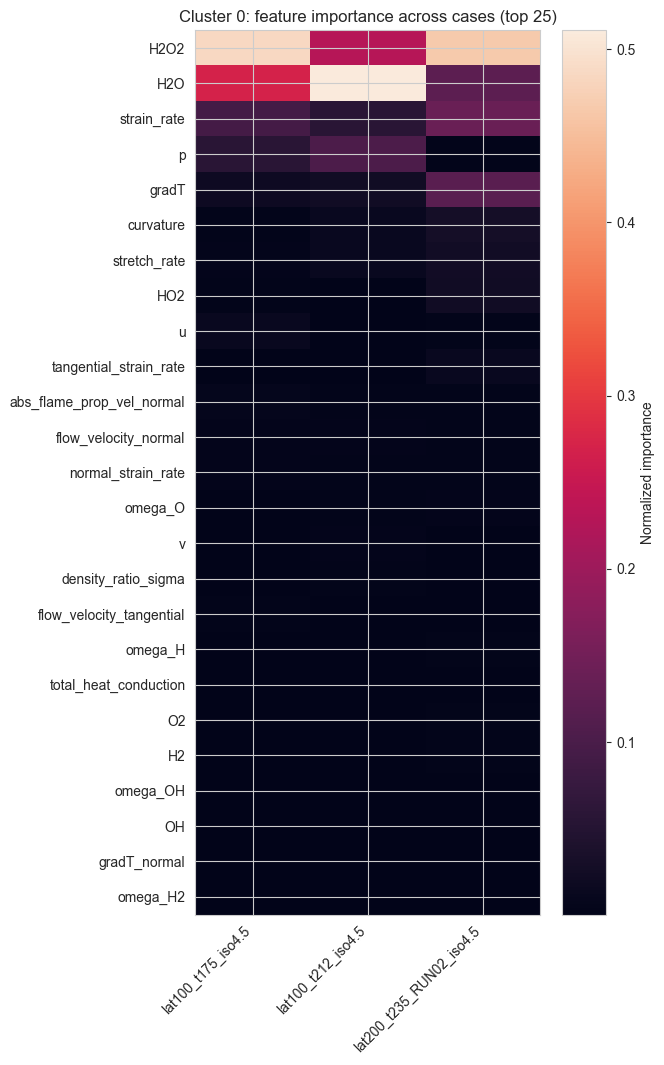

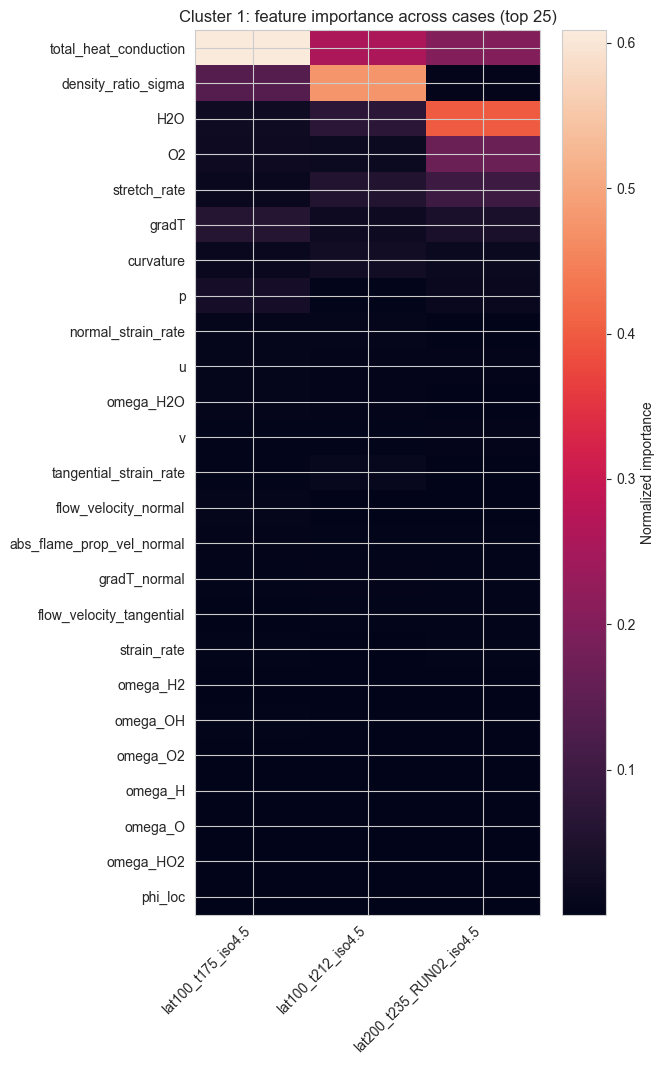

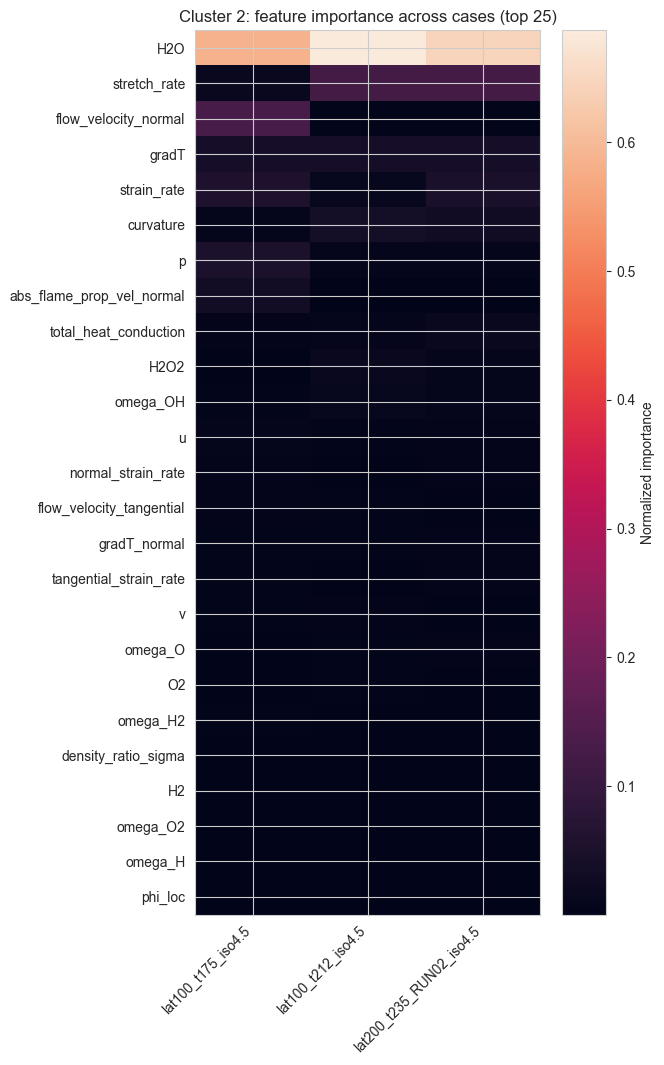

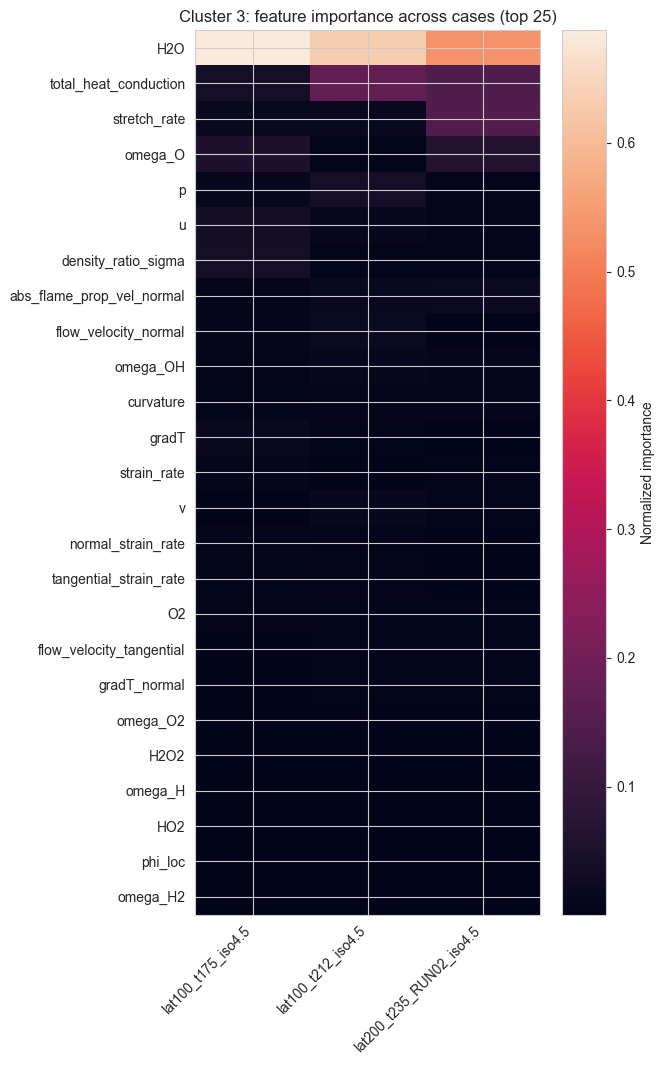

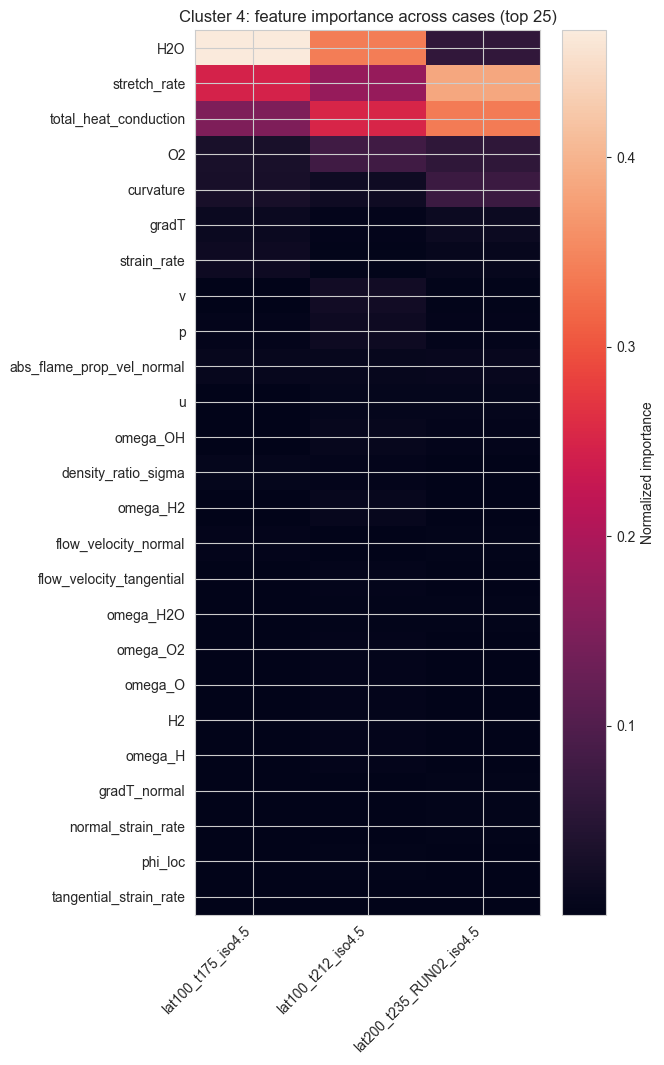


=== Reproducibility (pairwise across runs) ===
 cluster             case_i                   case_j  spearman  jaccard_topk
       0 lat100_t175_iso4.5       lat100_t212_iso4.5  0.771734      0.666667
       0 lat100_t212_iso4.5 lat200_t235_RUN02_iso4.5  0.727731      0.428571
       0 lat100_t175_iso4.5 lat200_t235_RUN02_iso4.5  0.646448      0.428571
       1 lat100_t175_iso4.5 lat200_t235_RUN02_iso4.5  0.933079      0.666667
       1 lat100_t175_iso4.5       lat100_t212_iso4.5  0.897021      0.666667
       1 lat100_t212_iso4.5 lat200_t235_RUN02_iso4.5  0.891826      0.538462
       2 lat100_t212_iso4.5 lat200_t235_RUN02_iso4.5  0.942552      0.818182
       2 lat100_t175_iso4.5 lat200_t235_RUN02_iso4.5  0.843850      0.428571
       2 lat100_t175_iso4.5       lat100_t212_iso4.5  0.818793      0.428571
       3 lat100_t212_iso4.5 lat200_t235_RUN02_iso4.5  0.892743      0.666667
       3 lat100_t175_iso4.5 lat200_t235_RUN02_iso4.5  0.864324      0.538462
       3 lat100_t175_iso4.5 

In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance


# =========================
# SETTINGS
# =========================

BASE_DIR = Path("../data/isocontours")
TARGET_VAR = "DW_FDS"

# IMPORTANT: use the SAME feature set for all cases (recommended)
# If you want to use "all numeric except exclude", set FIXED_FEATURES=None
FIXED_FEATURES: Optional[List[str]] = None

COLS_TO_EXCLUDE = ["x", "y", "z", TARGET_VAR, "N2", "omega_N2", "c_iso"]

CLUSTER_ON_SPATIAL = False
N_CLUSTERS = 5

GMM_PARAMS = dict(
    covariance_type="full",
    reg_covar=1e-6,
    max_iter=300,
    n_init=5,
    random_state=0,
)

MODEL_PARAMS = dict(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    random_state=0,
    n_jobs=-1,
)

TEST_SIZE = 0.25
RANDOM_STATE = 0
MIN_CLUSTER_SAMPLES = 100

TOPN_HEATMAP = 25
TOPK_JACCARD = 10


# =========================
# Case config + IO
# =========================

@dataclass(frozen=True)
class CaseConfig:
    phi: float = 0.40
    lat_size: str = "100"
    time_step: int = 212
    post: bool = True
    multiple_runs: bool = False
    n_RUN: int = 1
    Soret_term: bool = False
    Soret_positive: bool = False
    h_tag: str = "h400"


def case_folder(cfg: CaseConfig) -> Path:
    phi_dir = BASE_DIR / f"phi{cfg.phi:.2f}"

    if cfg.Soret_term and cfg.Soret_positive:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref_Soret_positive"
    elif cfg.Soret_term:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref"
    else:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref"

    if cfg.multiple_runs:
        folder = folder / f"RUN0{cfg.n_RUN}"

    return folder


def isofile_name(cfg: CaseConfig, c_val: float) -> str:
    if cfg.post:
        return f"extracted_flame_front_post_{cfg.time_step}_iso_{c_val}.csv"
    return f"extracted_flame_front_{cfg.time_step}_iso_{c_val}.csv"


def load_isotherm(cfg: CaseConfig, c_val: float) -> pd.DataFrame:
    fpath = case_folder(cfg) / isofile_name(cfg, c_val)
    if not fpath.exists():
        raise FileNotFoundError(f"Missing file:\n  {fpath}")
    df = pd.read_csv(fpath).copy()
    df["c_iso"] = float(c_val)
    return df


def numeric_feature_list(df: pd.DataFrame, exclude: List[str]) -> List[str]:
    return [c for c in df.columns if (c not in exclude) and pd.api.types.is_numeric_dtype(df[c])]


# =========================
# Importance
# =========================

def compute_importance(
    model,
    X_test: np.ndarray,
    y_test: np.ndarray,
    feature_names: List[str],
    prefer_shap: bool = True,
    random_state: int = 0,
) -> Tuple[pd.Series, str]:
    if prefer_shap:
        try:
            import shap  # type: ignore
            explainer = shap.TreeExplainer(model)
            shap_vals = explainer.shap_values(X_test)
            imp = np.mean(np.abs(shap_vals), axis=0)
            return pd.Series(imp, index=feature_names).sort_values(ascending=False), "shap"
        except Exception:
            pass

    pi = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=random_state,
        n_jobs=-1,
        scoring="r2",
    )
    return pd.Series(pi.importances_mean, index=feature_names).sort_values(ascending=False), "permutation"


# =========================
# Reference clustering fit
# =========================

def fit_reference_gmm(df_ref: pd.DataFrame, feature_cols: List[str]) -> Tuple[StandardScaler, GaussianMixture]:
    X = df_ref[feature_cols].to_numpy()
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    gmm = GaussianMixture(n_components=N_CLUSTERS, **GMM_PARAMS)
    gmm.fit(Xs)
    return scaler, gmm


def assign_clusters(df: pd.DataFrame, feature_cols: List[str], scaler: StandardScaler, gmm: GaussianMixture) -> pd.DataFrame:
    dfc = df.dropna(subset=feature_cols + [TARGET_VAR]).copy()
    X = dfc[feature_cols].to_numpy()
    Xs = scaler.transform(X)
    dfc["cluster"] = gmm.predict(Xs)
    dfc["cluster_conf"] = gmm.predict_proba(Xs).max(axis=1)
    return dfc


# =========================
# Per-case training + SHAP
# =========================

def run_case_models(dfc: pd.DataFrame, feature_cols: List[str], case_id: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      importance_long: rows = (case_id, cluster, feature, importance, method)
      metrics_df: rows = (case_id, cluster, n, r2, rmse, method)
    """
    importance_rows = []
    metrics_rows = []

    for cl in range(N_CLUSTERS):
        sub = dfc[dfc["cluster"] == cl].copy()
        n_cl = len(sub)
        if n_cl < MIN_CLUSTER_SAMPLES:
            continue

        X = sub[feature_cols].to_numpy()
        y = sub[TARGET_VAR].to_numpy()

        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

        model = RandomForestRegressor(**MODEL_PARAMS)
        model.fit(Xtr, ytr)

        ypred = model.predict(Xte)
        r2 = float(r2_score(yte, ypred))
        rmse = float(np.sqrt(mean_squared_error(yte, ypred)))

        imp, method = compute_importance(model, Xte, yte, feature_cols, prefer_shap=True, random_state=RANDOM_STATE)

        # normalize per cluster to sum to 1 (makes cross-case comparison fair)
        s = imp.sum()
        if s > 0:
            imp = imp / s

        for feat, val in imp.items():
            importance_rows.append(
                {"case_id": case_id, "cluster": cl, "feature": feat, "importance": float(val), "method": method}
            )

        metrics_rows.append(
            {"case_id": case_id, "cluster": cl, "n": n_cl, "r2": r2, "rmse": rmse, "method": method}
        )

    return pd.DataFrame(importance_rows), pd.DataFrame(metrics_rows)


# =========================
# Comparison utilities
# =========================

def jaccard_topk(a: pd.Series, b: pd.Series, k: int) -> float:
    A = set(a.sort_values(ascending=False).head(k).index)
    B = set(b.sort_values(ascending=False).head(k).index)
    return len(A & B) / max(1, len(A | B))


def spearman_corr(a: pd.Series, b: pd.Series) -> float:
    # align indices
    idx = a.index.intersection(b.index)
    if len(idx) < 3:
        return np.nan
    return float(a.loc[idx].rank().corr(b.loc[idx].rank(), method="pearson"))


def plot_importance_heatmap(imp_long: pd.DataFrame, cluster: int, topn: int = 25):
    sub = imp_long[imp_long["cluster"] == cluster].copy()
    if sub.empty:
        print(f"No importance data for cluster {cluster}")
        return

    pivot = sub.pivot_table(index="feature", columns="case_id", values="importance", aggfunc="mean").fillna(0.0)
    pivot["avg"] = pivot.mean(axis=1)
    top_feats = pivot.sort_values("avg", ascending=False).head(topn).index
    heat = pivot.loc[top_feats, pivot.columns.difference(["avg"])]

    plt.figure(figsize=(1.2 * heat.shape[1] + 3, 0.35 * heat.shape[0] + 2))
    plt.imshow(heat.to_numpy(), aspect="auto")
    plt.xticks(np.arange(heat.shape[1]), heat.columns, rotation=45, ha="right")
    plt.yticks(np.arange(heat.shape[0]), heat.index)
    plt.colorbar(label="Normalized importance")
    plt.title(f"Cluster {cluster}: feature importance across cases (top {topn})")
    plt.tight_layout()
    plt.show()


def reproducibility_scores(imp_long: pd.DataFrame, cluster: int, topk: int = 10) -> pd.DataFrame:
    sub = imp_long[imp_long["cluster"] == cluster].copy()
    pivot = sub.pivot_table(index="feature", columns="case_id", values="importance", aggfunc="mean").fillna(0.0)

    case_ids = list(pivot.columns)
    rows = []
    for i in range(len(case_ids)):
        for j in range(i + 1, len(case_ids)):
            ci, cj = case_ids[i], case_ids[j]
            a = pivot[ci]
            b = pivot[cj]
            rows.append({
                "cluster": cluster,
                "case_i": ci,
                "case_j": cj,
                "spearman": spearman_corr(a, b),
                "jaccard_topk": jaccard_topk(a, b, k=topk),
            })
    return pd.DataFrame(rows)


# ============================================================
# 1) DEFINE YOUR CASES TO COMPARE
# ============================================================

# Example cases (edit freely)
CASES: Dict[str, CaseConfig] = {
    "lat200_t235_RUN02": CaseConfig(phi=0.40, lat_size="200", time_step=235, post=True, multiple_runs=True, n_RUN=2),
    "lat100_t212": CaseConfig(phi=0.40, lat_size="100", time_step=212, post=True, multiple_runs=False, n_RUN=1),
    "lat100_t175":       CaseConfig(phi=0.40, lat_size="100", time_step=175, post=True, multiple_runs=False, n_RUN=1),
}

# Compare across these isotherms (can be one or many)
ISOLEVELS_TO_COMPARE = [4.5]   # or e.g. [4.0, 4.5, 4.7]

# Choose a REFERENCE case+isotherm for the GMM
REF_CASE_ID = list(CASES.keys())[0]
REF_ISO = ISOLEVELS_TO_COMPARE[0]


# ============================================================
# 2) PREPARE REFERENCE DATA + FEATURE SET
# ============================================================

df_ref = load_isotherm(CASES[REF_CASE_ID], REF_ISO)

exclude_for_cluster = list(COLS_TO_EXCLUDE)
if CLUSTER_ON_SPATIAL:
    for c in ["x", "y", "z"]:
        if c in exclude_for_cluster:
            exclude_for_cluster.remove(c)

if FIXED_FEATURES is None:
    FEATURE_COLS = numeric_feature_list(df_ref, exclude=exclude_for_cluster)
else:
    missing = [c for c in FIXED_FEATURES if c not in df_ref.columns]
    if missing:
        raise ValueError(f"FIXED_FEATURES missing in reference data: {missing}")
    FEATURE_COLS = FIXED_FEATURES

print(f"Using {len(FEATURE_COLS)} features.")


# ============================================================
# 3) FIT REFERENCE SCALER + GMM
# ============================================================

df_ref_clean = df_ref.dropna(subset=FEATURE_COLS + [TARGET_VAR]).copy()
scaler_ref, gmm_ref = fit_reference_gmm(df_ref_clean, FEATURE_COLS)
print(f"Reference GMM fitted on case={REF_CASE_ID}, iso={REF_ISO}")
print(f"Reference BIC: {gmm_ref.bic(scaler_ref.transform(df_ref_clean[FEATURE_COLS].to_numpy())):.2f}")


# ============================================================
# 4) LOOP OVER CASES x ISOLEVELS, ASSIGN CLUSTERS, TRAIN MODELS, COLLECT SHAP
# ============================================================

all_importance = []
all_metrics = []

for iso in ISOLEVELS_TO_COMPARE:
    for case_id, cfg in CASES.items():
        df_case = load_isotherm(cfg, iso)

        # ensure feature alignment exists in this case
        missing = [c for c in FEATURE_COLS if c not in df_case.columns]
        if missing:
            print(f"[SKIP] {case_id} iso={iso} missing features: {missing}")
            continue

        dfc = assign_clusters(df_case, FEATURE_COLS, scaler_ref, gmm_ref)

        # unique identifier: case + iso
        run_id = f"{case_id}_iso{iso}"

        imp_long, met_df = run_case_models(dfc, FEATURE_COLS, case_id=run_id)
        all_importance.append(imp_long)
        all_metrics.append(met_df)

importance_long = pd.concat(all_importance, ignore_index=True) if all_importance else pd.DataFrame()
metrics_df = pd.concat(all_metrics, ignore_index=True) if all_metrics else pd.DataFrame()

print("\n=== Metrics summary (per cluster, per run) ===")
print(metrics_df.sort_values(["case_id", "cluster"]).to_string(index=False))


# ============================================================
# 5) VISUALIZE + QUANTIFY REPRODUCIBILITY
# ============================================================

# Heatmap per cluster
for cl in range(N_CLUSTERS):
    plot_importance_heatmap(importance_long, cluster=cl, topn=TOPN_HEATMAP)

# Reproducibility scores per cluster (pairwise across runs)
rep_all = []
for cl in range(N_CLUSTERS):
    rep = reproducibility_scores(importance_long, cluster=cl, topk=TOPK_JACCARD)
    if not rep.empty:
        rep_all.append(rep)

rep_df = pd.concat(rep_all, ignore_index=True) if rep_all else pd.DataFrame()

print("\n=== Reproducibility (pairwise across runs) ===")
if not rep_df.empty:
    print(rep_df.sort_values(["cluster", "spearman"], ascending=[True, False]).to_string(index=False))

    # Aggregate reproducibility per cluster
    agg = rep_df.groupby("cluster").agg(
        spearman_mean=("spearman", "mean"),
        jaccard_mean=("jaccard_topk", "mean"),
        n_pairs=("spearman", "size"),
    ).reset_index()
    print("\n=== Aggregate reproducibility per cluster ===")
    print(agg.to_string(index=False))
else:
    print("No reproducibility data (not enough runs/clusters).")
